In [1]:
import openmc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py
import pyvista as pv
import openmc.mgxs as mgxs

################################################################################
#Materials
################################################################################
#Plutonium (PuBe)
PuBe = openmc.Material(name = 'PuBe')
PuBe.add_nuclide('Pu239', 1) #, 0.5, 'ao')
PuBe.add_element('Be', 1)#, 0.5, 'ao')
PuBe.set_density('g/cm3', 2.0)

################################################################################
#Aluminum Cladding
aluminum_cladding = openmc.Material(name = 'Aluminum Cladding')
aluminum_cladding.add_element('Al', 1.0)
aluminum_cladding.set_density('g/cm3', 2.7)

################################################################################
#Fuel (UO2)
fuel = openmc.Material(name='UO2 Fuel')
fuel.add_element('U', 1)
fuel.add_element('O', 2)
fuel.set_density('g/cm3', 10.5)

################################################################################
#Graphite Moderator
graphite = openmc.Material(name='Graphite')
graphite.add_element('C', 1.0)
graphite.set_density('g/cm3', 1.7)

################################################################################
#Air
air = openmc.Material(name='Air')
air.add_element('N', 0.78084)
air.add_element('O', 0.209476)
air.add_element('Ar', 0.00934)
air.set_density('g/cm3', 0.001204)

################################################################################
#Concrete
concrete = openmc.Material(name='Concrete')
concrete.add_element('H', 0.149857)
concrete.add_element('C', 0.074206)
concrete.add_element('O', 0.526836)
concrete.add_element('Mg', 0.017713)
concrete.add_element('Al', 0.023794)
concrete.add_element('Si', 0.091975)
concrete.add_element('S', 0.001649)
concrete.add_element('K', 0.000773)
concrete.add_element('Ca', 0.109681)
concrete.add_element('Fe', 0.003516)
concrete.set_density('g/cm3', 2.35)

################################################################################
#Export Materials
materials = openmc.Materials([fuel, PuBe, aluminum_cladding, graphite, air, concrete])
materials.export_to_xml()

################################################################################
#Brick dimensions in the x-y-z planes
brick_side_length_x  = 15
brick_side_length_y  = 15
brick_side_length_z  = 50.0

################################################################################
# Radii
r_air_hole = 0.46
r_inner_clad = 0.61875
r_fuel = 1.76125
r_outer_clad = 1.92

# Lengths
total_length = 135.0
air_gap_back = 15.0

#Dimensions in total:
x_direction = 165.24
y_direction = 180
z_direction = 150

################################################################################
#Read from .csv file which has grid locations
#Grid location is at the center of each brick it seems
# Load the CSV file

try:
    # Make sure to include the actual filename at the end of the path
    data = pd.read_csv('YZ_Locations.csv')
except Exception as e:
    print(f"Error reading the CSV file: {e}")

################################################################################
#Create Graphite Bricks
universe_cells = []

################################################################################
# Create Geometry

#Reactor Boundary Condtions
x_min = openmc.XPlane(x0=0, boundary_type='vacuum')
x_max = openmc.XPlane(x0=150+15.24, boundary_type='vacuum')
y_min = openmc.YPlane(y0=0, boundary_type='vacuum')
y_max = openmc.YPlane(y0=180, boundary_type='vacuum')
z_min = openmc.ZPlane(z0=0, boundary_type='vacuum')
z_max = openmc.ZPlane(z0=150, boundary_type='vacuum')


# Combine the boundary planes to form a cuboid region
reactor_boundary = (+x_min & -x_max & +y_min & -y_max & +z_min & -z_max)


############################################################################
for index, row in data.iterrows():
    y_center, z_center = row['Y'], row['Z']

    # Define the fuel region with a single cylinder per hole
    z_plane_start = openmc.ZPlane(z0=0)
    z_plane_air = openmc.ZPlane(z0=total_length)
    z_plane_end = openmc.ZPlane(z0=z_direction)

    # Define cylinders for air hole, cladding, and fuel
    air_hole   = openmc.ZCylinder(r=r_air_hole,   x0=y_center, y0=z_center, boundary_type='transmission')
    inner_clad = openmc.ZCylinder(r=r_inner_clad, x0=y_center, y0=z_center, boundary_type='transmission')
    fuel_rod   = openmc.ZCylinder(r=r_fuel,       x0=y_center, y0=z_center, boundary_type='transmission')
    outer_clad = openmc.ZCylinder(r=r_outer_clad, x0=y_center, y0=z_center, boundary_type='transmission')

    # Define cells for air hole, cladding, and fuel
    air_hole_cell = openmc.Cell(name=f'Air Hole {index}', fill=air)
    air_hole_cell.region = -air_hole & +z_plane_start & -z_plane_air

    inner_clad_cell = openmc.Cell(name=f'Inner Cladding {index}', fill=aluminum_cladding)
    inner_clad_cell.region = +air_hole & -inner_clad & +z_plane_start & -z_plane_air

    fuel_cell = openmc.Cell(name=f'Fuel Rod {index}', fill=fuel)
    fuel_cell.region = +inner_clad & -fuel_rod & +z_plane_start & -z_plane_air

    outer_clad_cell = openmc.Cell(name=f'Outer Cladding {index}', fill=aluminum_cladding)
    outer_clad_cell.region = +fuel_rod & -outer_clad & +z_plane_start & -z_plane_air

    # Append all cells to universe
    universe_cells.extend([air_hole_cell, inner_clad_cell, fuel_cell, outer_clad_cell])
    
    graphite_brick_1 = openmc.model.RectangularParallelepiped(
        xmin=(y_center - brick_side_length_x/2),
        xmax=(y_center + brick_side_length_x/2),
        ymin=(z_center - brick_side_length_y/2),
        ymax=(z_center + brick_side_length_y/2),
        zmin=0,
        zmax=135,
        boundary_type='transmission')

    graphite_cell_1 = openmc.Cell(name=f'Graphite Brick 1 {index}', fill=graphite)
    graphite_cell_1.region = -graphite_brick_1 & +outer_clad
    universe_cells.append(graphite_cell_1)


    #Don't forget about the 15 cm air gap on the back
    air_cylinder = openmc.ZCylinder(r=r_outer_clad, x0=y_center, y0=z_center, boundary_type='transmission')
    air_cell = openmc.Cell(name=f'Air Gap {index}', fill=air)
    air_cell.region = -air_cylinder & +z_plane_air & -z_plane_end 
    universe_cells.append(air_cell)
    
    graphite_brick_4 = openmc.model.RectangularParallelepiped(
        xmin=(y_center - brick_side_length_x/2),
        xmax=(y_center + brick_side_length_x/2),
        ymin=(z_center - brick_side_length_y/2),
        ymax=(z_center + brick_side_length_y/2),
        zmin=135,
        zmax=150,
        boundary_type='transmission')

    graphite_cell_4 = openmc.Cell(name=f'Graphite Brick 4 {index}', fill=graphite)
    graphite_cell_4.region = -graphite_brick_4 & +air_cylinder
    universe_cells.append(graphite_cell_4)

############################################################################
#Create Plutonium Fuel

Plutonium_source = openmc.Sphere(x0=75, y0=15, z0=75, r=2, boundary_type='transmission')
Plutonium_source_cell = openmc.Cell(name='Plutonium fuel', fill=PuBe)
Plutonium_source_cell.region = -Plutonium_source

universe_cells.append(Plutonium_source_cell)

############################################################################
#Create Graphite Floor
Graphite_floor = openmc.model.RectangularParallelepiped(
    xmin= 0,
    xmax= 150,
    ymin= 0,
    ymax= 30,
    zmin= 0,
    zmax= 150,
    boundary_type='transmission')

Graphite_floor_cell = openmc.Cell(name='Graphite floor', fill=graphite)
Graphite_floor_cell.region = -Graphite_floor & +Plutonium_source

universe_cells.append(Graphite_floor_cell)

############################################################################
#Create concrete wall
Concrete_wall = openmc.model.RectangularParallelepiped(
    xmin= 150,
    xmax= 150+15.24,
    ymin= 0,
    ymax= 180,
    zmin= 0,
    zmax= 150,
    boundary_type='transmission')

Concrete_wall_cell = openmc.Cell(name='Concrete wall', fill=concrete)
Concrete_wall_cell.region = -Concrete_wall 

universe_cells.append(Concrete_wall_cell)

################################################################################
# Create a universe and add all cells
universe = openmc.Universe(cells=universe_cells)

# Create a root cell and assign it the reactor boundary
root_cell = openmc.Cell(name='Root Boundary', region=reactor_boundary)
root_cell.fill = universe  # Fill the root cell with the defined universe

# Create a root universe containing the root cell
root_universe = openmc.Universe(name='root', cells=[root_cell])

# Create a Geometry and assign the universe as the root
geometry = openmc.Geometry(root_universe)

material_colors = {
    PuBe: 'yellow',                # Plutonium-Beryllium in yellow
    aluminum_cladding: 'grey',     # Aluminum Cladding in grey
    fuel: 'red',                   # Fuel (UO2) in red
    graphite: 'black',             # Graphite in black
    air: 'blue',                   # Air in blue
    concrete: 'brown'              # Concrete in brown
}

# plot_xy = openmc.Plot()
# plot_xy.basis = 'xy'
# plot_xy.origin = (75.0, 90.0, 75.0)
# plot_xy.width = (200., 200.)
# plot_xy.pixels = (4000, 4000)
# plot_xy.color_by = 'material'
# plot_xy.colors = material_colors

# plot_xz = openmc.Plot()
# plot_xz.basis = 'xz'
# plot_xz.origin = (75.0, 90.0, 75.0)
# plot_xz.width = (150., 180.)
# plot_xz.pixels = (400, 400)
# plot_xz.color_by = 'material'
# plot_xz.colors = material_colors

# plot_yz = openmc.Plot()
# plot_yz.basis = 'yz'
# plot_yz.origin = (75.0, 90.0, 75.0)
# plot_yz.width = (150., 180.)
# plot_yz.pixels = (400, 400)
# plot_yz.color_by = 'material'
# plot_yz.colors = material_colors


# Make Voxel Plots

# Add a voxel plot
# voxel_plot = openmc.Plot()
# voxel_plot.type = 'voxel'
# voxel_plot.origin = (75, 90, 75)  # Origin of the voxel plot
# voxel_plot.width = (200, 200, 200)  # Width of the voxel plot in x, y, z
# voxel_plot.pixels = (4000, 4000, 4000)  # Resolution of the voxel plot

# # Export voxel plot settings
# plots = openmc.Plots([voxel_plot])
# plots.export_to_xml()

# # plots = openmc.Plots([plot_xy, plot_xz, plot_yz])
# # plots.export_to_xml()
# openmc.plot_geometry()

# Export the geometry to XML
geometry.export_to_xml()

################################################################################
# Settings Setup
################################################################################
# Define a source - Assume a simple isotropic point source in the middle as our initial guess
point = openmc.stats.Point((75, 75, 75))
source = openmc.Source(space=point, strength=1e9)
source.particle = 'neutron'

################################################################################
# Multigroup Setup, do this later
################################################################################

################################################################################
# Setup simulation settings
settings = openmc.Settings()
settings.source = source
settings.batches = 20
settings.inactive = 10
settings.particles = 1000000
settings.export_to_xml()
settings.create_fission_neutrons = True

################################################################################
# Define a mesh that spans the x-y plane at z=60 cm
mesh_flux = openmc.RegularMesh()
mesh_flux.dimension   = [400, 400, 400]  # Focus on a single plane in z-direction
mesh_flux.lower_left  = [0, 0, 0]  # Lower left corner of the mesh
mesh_flux.upper_right = [165.24, 180, 150]  

################################################################################
# Define a mesh tally for neutron flux at z=60 cm
tally_flux = openmc.Tally(name='Flux and Fission')
tally_flux.filters = [openmc.MeshFilter(mesh_flux)]
tally_flux.scores = ['flux', 'fission']

# Add tally to the tallies collection
tallies = openmc.Tallies()
tallies.append(tally_flux)
tallies.export_to_xml()

################################################################################
# Assemble and Run
model = openmc.model.Model(geometry, materials, settings, tallies=tallies)
model.run(threads=16)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

KeyboardInterrupt: 

In [6]:
import openmc
import matplotlib.pyplot as plt
import numpy as np

# Load the statepoint file
sp = openmc.StatePoint('statepoint.20.h5')

# Access the flux tally
flux_tally = sp.get_tally(name='Flux and Fission')

flux = flux_tally.get_slice(scores=['flux'])

flux.std_dev.shape = (8000, 8000)
flux.mean.shape = (8000, 8000)

# fission_tally = sp.get_tally(name='Flux and Fission')
# fission = flux_tally.get_slice(scores=['fission'])
# fission.std_dev.shape = (8000, 8000)
# fission.mean.shape = (8000, 8000)


# Determine relative error
relative_error = np.zeros_like(flux.std_dev)
nonzero = flux.mean > 0
relative_error[nonzero] = flux.std_dev[nonzero] / flux.mean[nonzero]

# distribution of relative errors
ret = plt.hist(relative_error[nonzero], bins=50)

KeyboardInterrupt: 

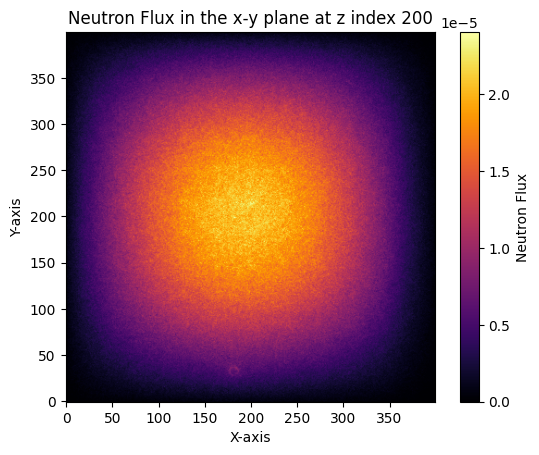

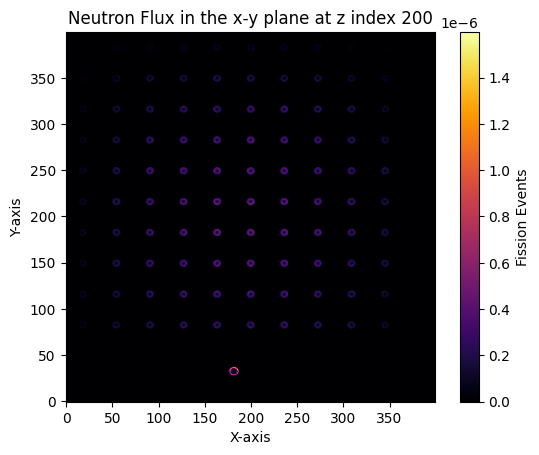

AttributeError: 'numpy.ndarray' object has no attribute 'std_dev'

In [2]:
import openmc
import matplotlib.pyplot as plt
import numpy as np

# Load the statepoint file
sp = openmc.StatePoint('statepoint.20.h5')
# Access the flux tally
flux_tally = sp.get_tally(name='Flux and Fission')
# Get the tally data as a numpy array
flux_data = flux_tally.get_values(scores=['flux'])
# Total number of data points
total_data_points = 400**3

# Since the data is from a cubic mesh, we take the cube root to find the size of one dimension
mesh_dimension_size = np.round(np.cbrt(total_data_points)).astype(int)
flux_data_reshaped = flux_data.reshape((mesh_dimension_size, mesh_dimension_size, mesh_dimension_size))

# Loop over z-slice indices from 0 to 150
for z_slice_index in range(200, 201):  # Includes 0 through 150
    # Extract the 2D data for the x-y plane at the given z index
    flux_data_2d = flux_data_reshaped[z_slice_index, :, :]
    
    # Generate the heatmap for the x-y slice
    plt.imshow(flux_data_2d, origin='lower', cmap='inferno')
    plt.colorbar(label='Neutron Flux')
    plt.title(f'Neutron Flux in the x-y plane at z index {z_slice_index}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()



fission_tally = sp.get_tally(name='Flux and Fission')
fission_data = fission_tally.get_values(scores=['fission'])
fission_data_reshaped = fission_data.reshape((mesh_dimension_size, mesh_dimension_size, mesh_dimension_size))

# Loop over z-slice indices from 0 to 150
for z_slice_index in range(200, 201):  # Includes 0 through 150
    # Extract the 2D data for the x-y plane at the given z index
    fission_data_2d = fission_data_reshaped[z_slice_index, :, :]
    
    # Generate the heatmap for the x-y slice
    plt.imshow(fission_data_2d, origin='lower', cmap='inferno')
    plt.colorbar(label='Fission Events')
    plt.title(f'Neutron Flux in the x-y plane at z index {z_slice_index}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


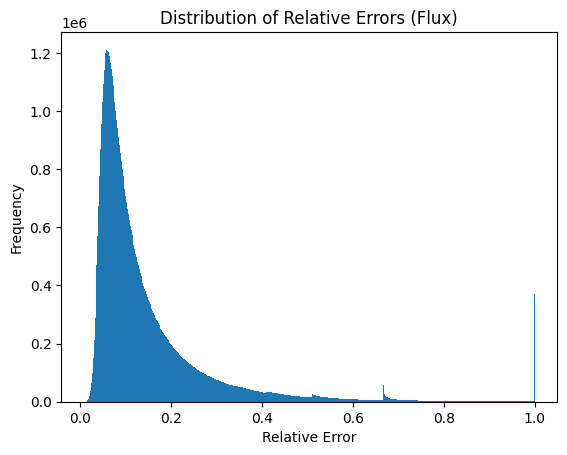

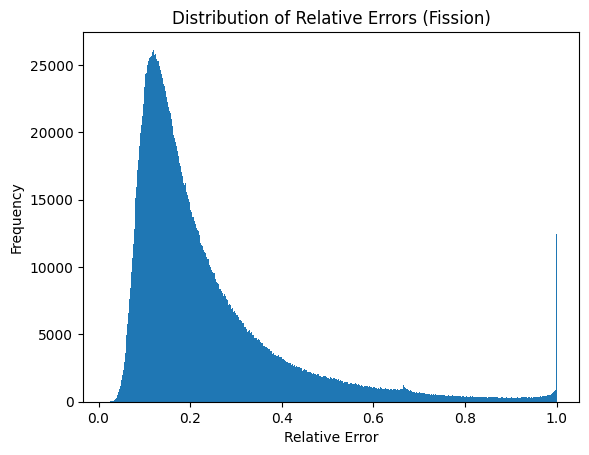

In [4]:
import openmc
import matplotlib.pyplot as plt
import numpy as np

# Load the statepoint file
sp = openmc.StatePoint('statepoint.20.h5')

# Access the flux tally
flux_tally = sp.get_tally(name='Flux and Fission')

# Get the mean and standard deviation for the flux tally
flux_mean = flux_tally.get_values(scores=['flux'], value='mean')
flux_std_dev = flux_tally.get_values(scores=['flux'], value='std_dev')

# Total number of data points
total_data_points = 400**3

# Since the data is from a cubic mesh, we take the cube root to find the size of one dimension
mesh_dimension_size = np.round(np.cbrt(total_data_points)).astype(int)

# Reshape the mean and std_dev data to the mesh dimensions
flux_mean_reshaped = flux_mean.reshape((mesh_dimension_size, mesh_dimension_size, mesh_dimension_size))
flux_std_dev_reshaped = flux_std_dev.reshape((mesh_dimension_size, mesh_dimension_size, mesh_dimension_size))

# Compute the relative error
relative_error = np.zeros_like(flux_mean_reshaped)
nonzero = flux_mean_reshaped > 0
relative_error[nonzero] = flux_std_dev_reshaped[nonzero] / flux_mean_reshaped[nonzero]

# Plot the distribution of relative errors
plt.hist(relative_error[nonzero], bins=500)
plt.title("Distribution of Relative Errors (Flux)")
plt.xlabel("Relative Error")
plt.ylabel("Frequency")
plt.show()

# Access the fission tally
fission_tally = sp.get_tally(name='Flux and Fission')

# Get the mean and standard deviation for the fission tally
fission_mean = fission_tally.get_values(scores=['fission'], value='mean')
fission_std_dev = fission_tally.get_values(scores=['fission'], value='std_dev')

# Reshape the mean and std_dev data to the mesh dimensions
fission_mean_reshaped = fission_mean.reshape((mesh_dimension_size, mesh_dimension_size, mesh_dimension_size))
fission_std_dev_reshaped = fission_std_dev.reshape((mesh_dimension_size, mesh_dimension_size, mesh_dimension_size))

# Compute the relative error
relative_error_fission = np.zeros_like(fission_mean_reshaped)
nonzero_fission = fission_mean_reshaped > 0
relative_error_fission[nonzero_fission] = fission_std_dev_reshaped[nonzero_fission] / fission_mean_reshaped[nonzero_fission]

# Plot the distribution of relative errors for fission
plt.hist(relative_error_fission[nonzero_fission], bins=500)
plt.title("Distribution of Relative Errors (Fission)")
plt.xlabel("Relative Error")
plt.ylabel("Frequency")
plt.show()


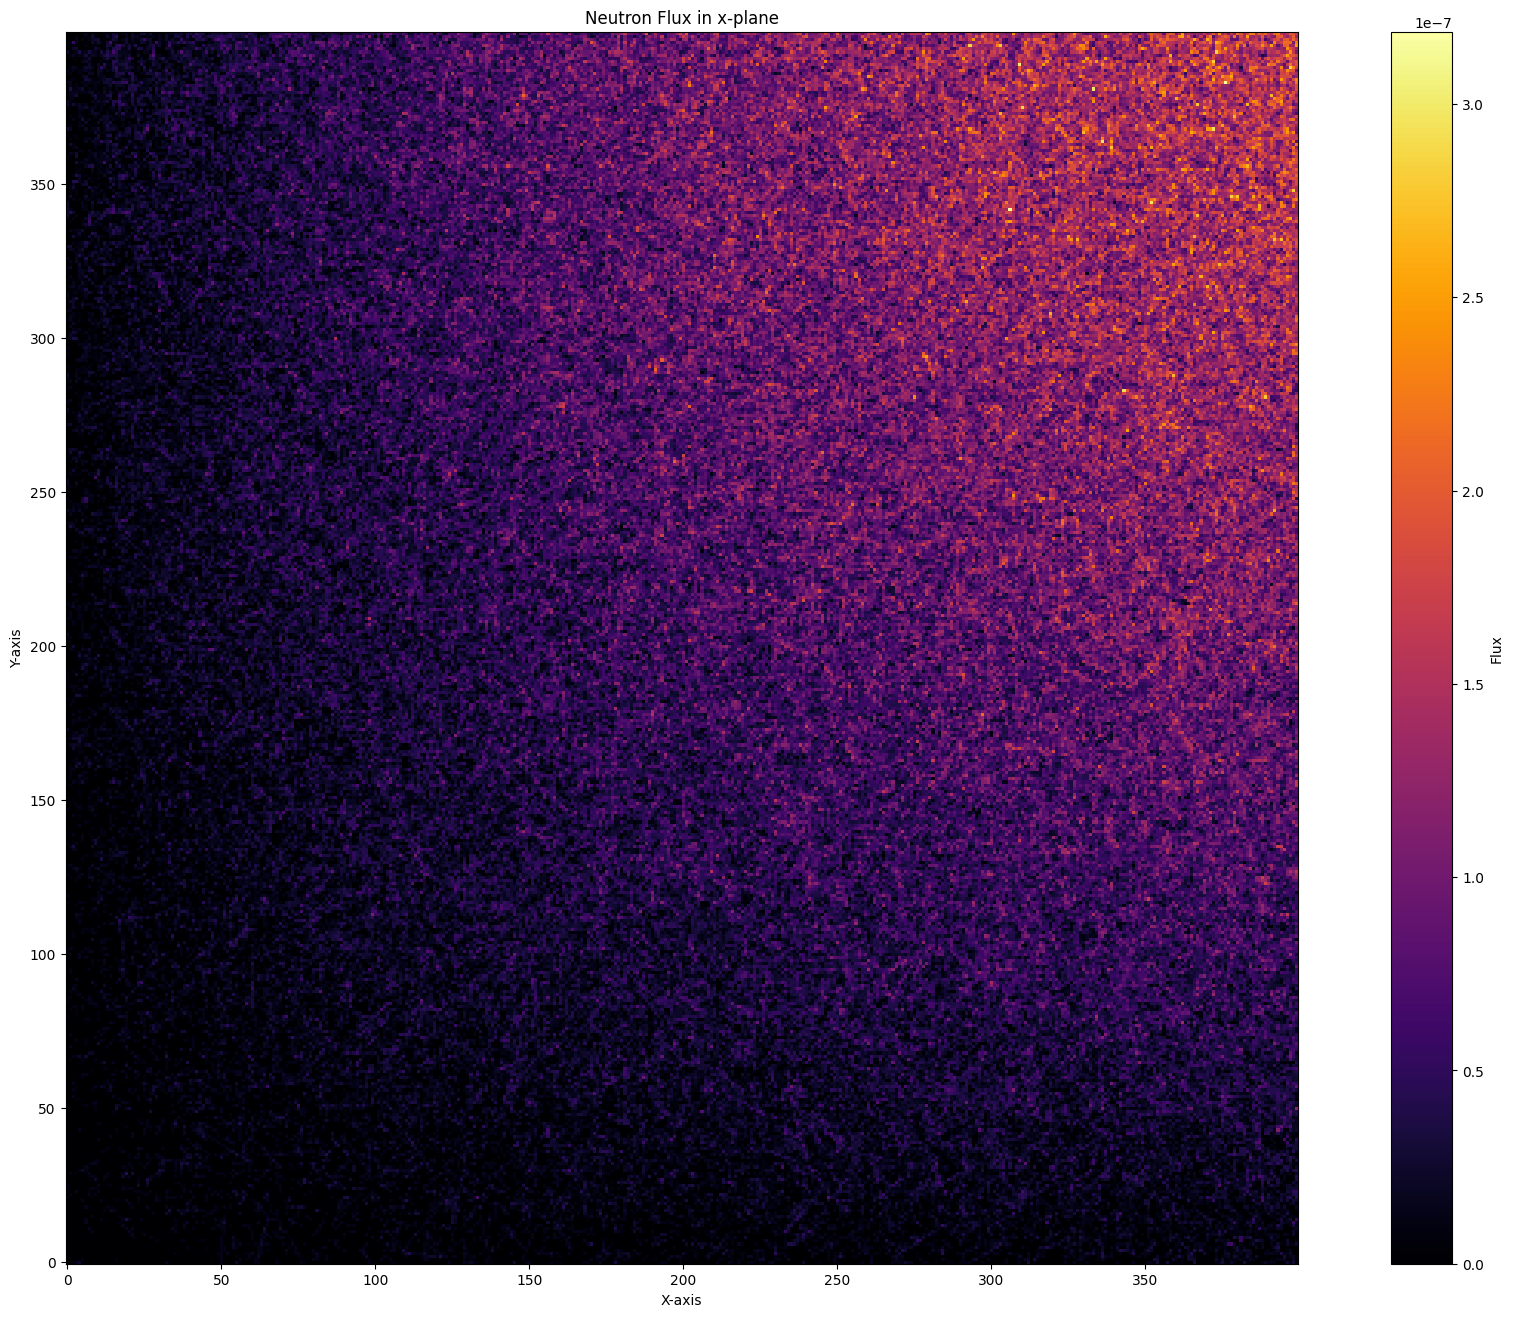

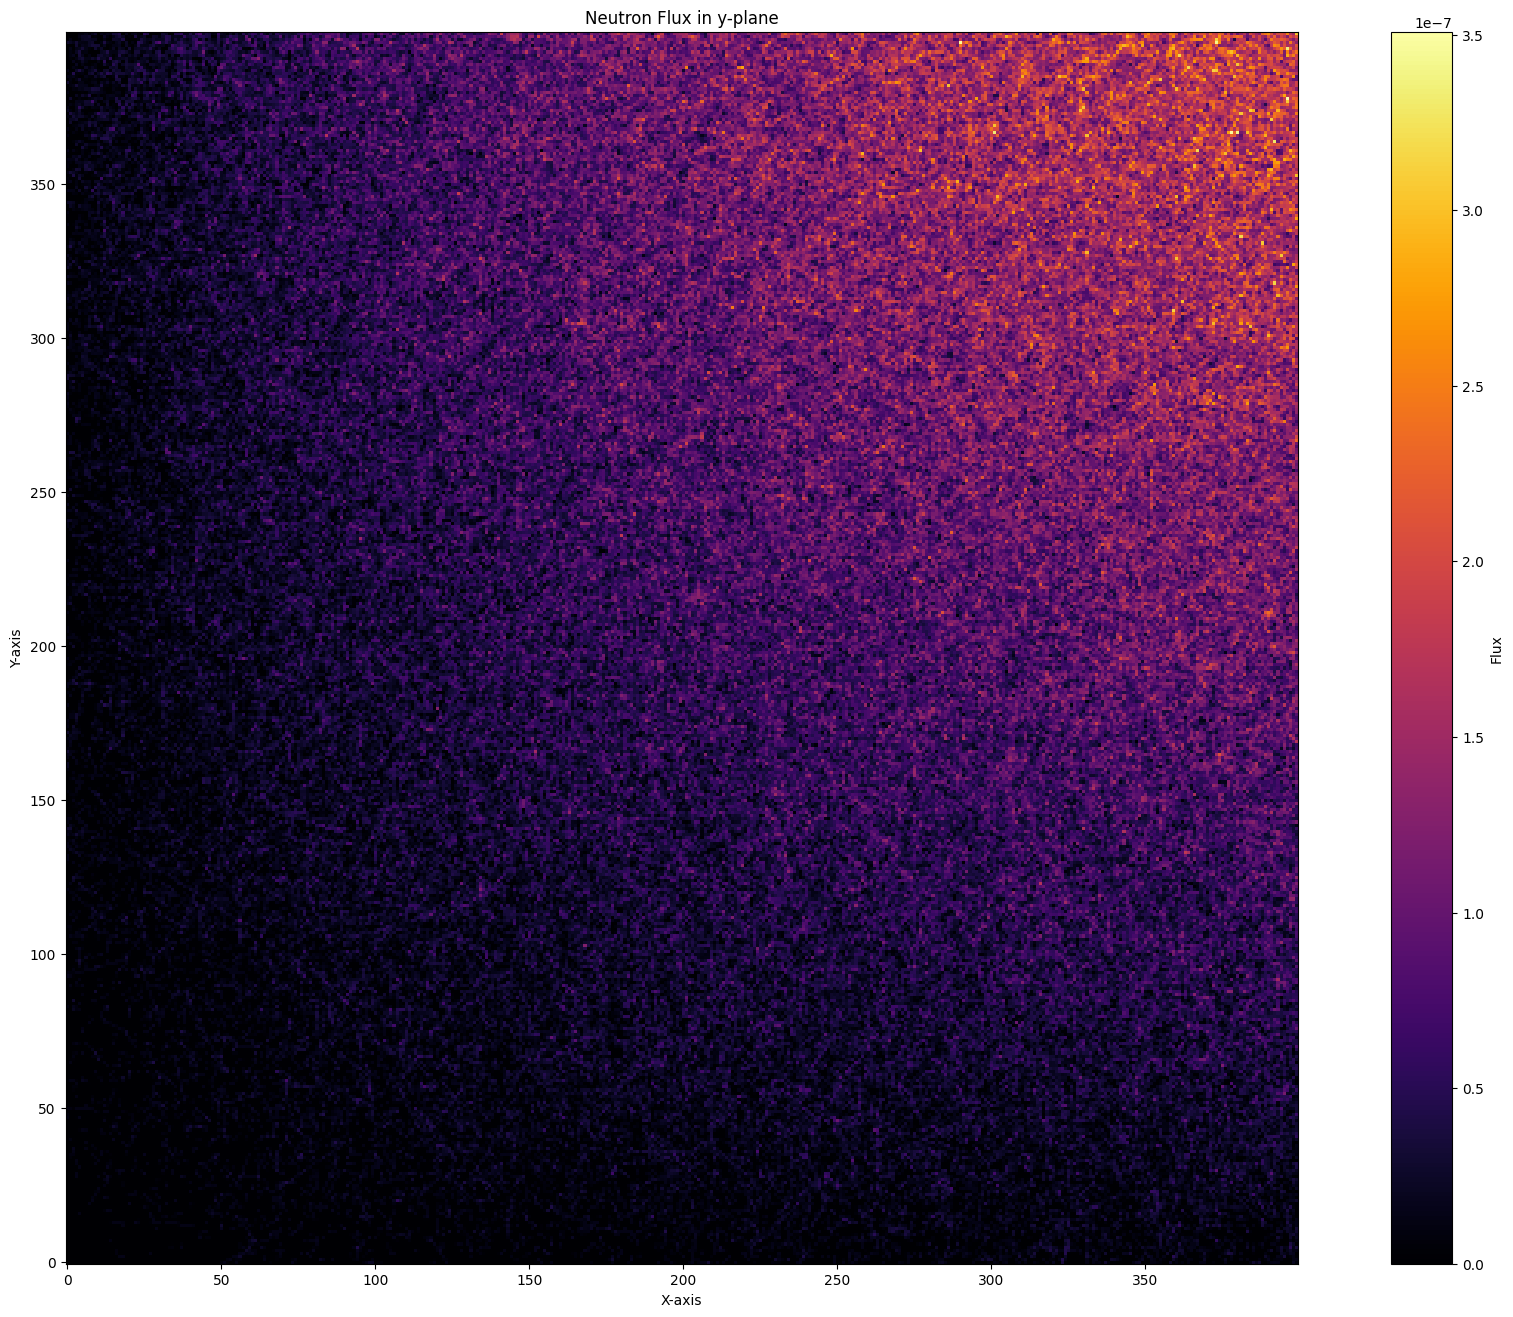

(64000000, 1, 1)


KeyboardInterrupt: 

In [2]:
import matplotlib.colors as colors  
# 
# Load the statepoint file
sp = openmc.StatePoint('statepoint.20.h5')

# Extract the desired tally
flux_tally = sp.get_tally(name='flux_at_60cm')  # Ensure the name matches exactly
# fission_tally = sp.get_tally(name='fission_at_60cm')
# Get the flux data
flux_data = flux_tally.get_values(scores=['flux'])
# fission_data = fission_tally.get_values(scores=['fission'])

# Reshape the data to fit the mesh dimensions
mesh_dimension = [400, 400, 400]
flux_reshaped = flux_data.reshape(mesh_dimension)
# fission_reshaped = fission_data.reshape(mesh_dimension)


def plot_flux_plane_enhanced(flux_data, plane, idx, cmap='inferno', log_norm=False):
    if plane == 'x':
        data_to_plot = flux_data[:, idx, :]
    elif plane == 'y':
        data_to_plot = flux_data[idx, :, :]
    else:
        raise ValueError("Invalid plane. Use 'x' or 'y'.")

    plt.figure(figsize=(24, 16))

    # Choose normalization method
    if log_norm:
        norm = colors.LogNorm(vmin=np.min(data_to_plot[data_to_plot > 0]), vmax=np.max(data_to_plot))
    else:
        norm = colors.Normalize(vmin=np.min(data_to_plot), vmax=np.max(data_to_plot))

    plt.imshow(data_to_plot, origin='lower', cmap=cmap, norm=norm)
    plt.colorbar(label='Flux')
    plt.title(f'Neutron Flux in {plane}-plane')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

# Example plots with logarithmic normalization
plot_flux_plane_enhanced(flux_reshaped, 'x', 200, cmap='inferno', log_norm=False)
plot_flux_plane_enhanced(flux_reshaped, 'y', 200, cmap='inferno', log_norm=False)

# def plot_fission_plane_enhanced(fission_data, plane, idx, cmap='inferno', log_norm=False):
#     if plane == 'x':
#         data_to_plot = fission_data[:, idx, :]
#     elif plane == 'y':
#         data_to_plot = fission_data[idx, :, :]
#     else:
#         raise ValueError("Invalid plane. Use 'x' or 'y'.")

#     plt.figure(figsize=(24, 16))

#     # Choose normalization method
#     if log_norm:
#         norm = colors.LogNorm(vmin=np.min(data_to_plot[data_to_plot > 0]), vmax=np.max(data_to_plot))
#     else:
#         norm = colors.Normalize(vmin=np.min(data_to_plot), vmax=np.max(data_to_plot))

#     plt.imshow(data_to_plot, origin='lower', cmap=cmap, norm=norm)
#     plt.colorbar(label='Flux')
#     plt.title(f'Neutron Flux in {plane}-plane')
#     plt.xlabel('X-axis')
#     plt.ylabel('Y-axis')
#     plt.show()

# Example plots with logarithmic normalization
# plot_fission_plane_enhanced(fission_reshaped, 'x', 200, cmap='inferno', log_norm=False)
# plot_fission_plane_enhanced(fission_reshaped, 'y', 200, cmap='inferno', log_norm=False)

tally = sp.get_tally(scores=['flux'])
# print(tally)

tally.sum
print(tally.mean.shape)
(tally.mean, tally.std_dev)
flux = tally.get_slice(scores=['flux'])
# fission = tally.get_slice(scores=['fission'])
# print(flux)

# Reshape the data to (200, 200, 200)
flux_mean_reshaped = flux.mean.reshape((400, 400, 400))
flux_std_dev_reshaped = flux.std_dev.reshape((400, 400, 400))

# Visualize a specific plane, for example, the middle of the x-axis
x_idx = 200  # Middle index along the x-axis

# Create plots
plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.imshow(flux_mean_reshaped[x_idx, :, :], cmap='inferno')
plt.colorbar()
plt.title('Flux Mean at x=100')

plt.subplot(1, 2, 2)
plt.imshow(flux_std_dev_reshaped[x_idx, :, :], cmap='inferno')
plt.colorbar()
plt.title('Flux Standard Deviation at x=100')

plt.tight_layout()
plt.show()

In [ ]:
### ADD MULTIGROUP CROSS SECTIONS